<a href="https://colab.research.google.com/github/Kev1nWangsus/ECE188DeepLearning/blob/main/Adv_example_Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perform an Adversarial attack.

For the second part of the project we consider a trained model (MobileNet) which is trained on the imagenet dataset. 

We use an evasion attack called [FGSM](https://neptune.ai/blog/adversarial-attacks-on-neural-networks-exploring-the-fast-gradient-sign-method#:~:text=The%20Fast%20Gradient%20Sign%20Method%20(FGSM)%20combines%20a%20white%20box,model%20into%20making%20wrong%20predictions.) to fool the neural network into making incorrect predictions.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Packages.

Import the necessary packages we continue to use Tensorflow and Keras

In [2]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras.preprocessing import image
import pandas

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

## Load the Pretrained model. 

We use the [MobileNetV2](https://arxiv.org/abs/1801.04381) model trained on the [Imagenet](https://www.image-net.org/) dataset. 

In [3]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14548992/14536120 [==============================] - 0s 0us/step


### Helper Function for Data Processing


Following functions can be used for data processing. Dont worry about these, just use them. 

In [4]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

## Load an Image. 


Load any image, we consider an image of a Golden Retriever. 

In [5]:
image_raw = tf.io.read_file('/content/drive/MyDrive/images/panda.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

49152/35363 [=========================================] - 0s 0us/step


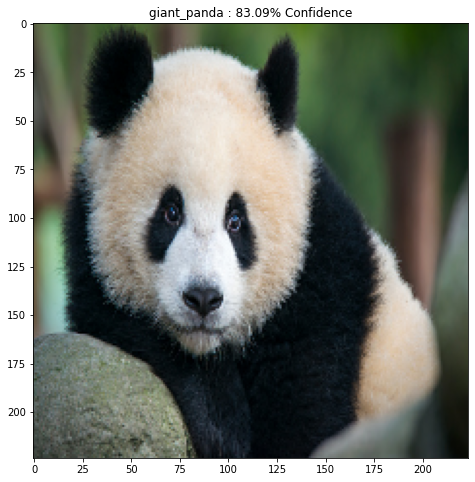

In [6]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## Create the Adversarial Image. 

We use the FGSM method to create an adversarial image. Be sure to read about FGSM to understand how the attack works. 

In [7]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

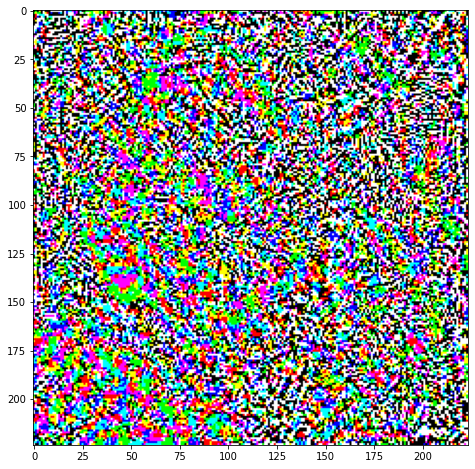

In [8]:
# Get the input label of the image.
giant_panda_index = 388
label = tf.one_hot(giant_panda_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [9]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

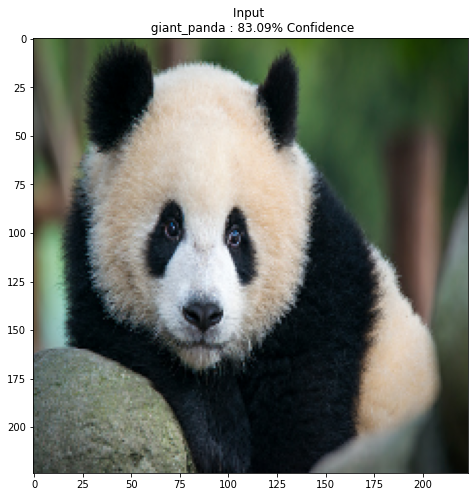

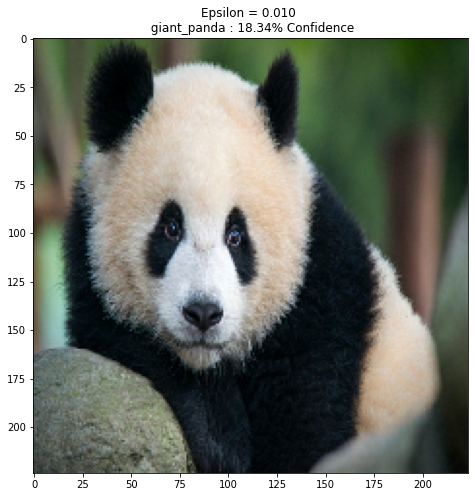

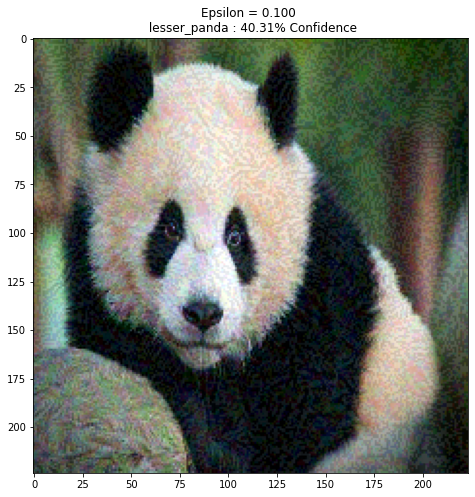

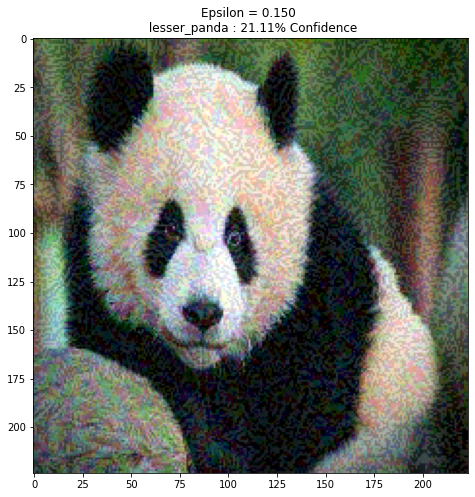

In [10]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

# Task2: Perform an Analysis to understand the potency of the attack. 

Your task here is to understand how small a change could change the class output and this is measured by the epsilon value needed to change the class. 

Your task is as follows:

* Pick 10 images each from different classes in imagenet. 
* Perform a perturbation analysis on each of these images. 
* In the analysis you are required to report the smallest epsilon value for which you notice a class change. 
* Make a table for each of the images considered with the minimum epsilon value for the FGSM attack. 

Write the Code for the above below. You can add the table also below. 

| Class | Index |
|------|------|
|  Hen | 8 |
| Pelican | 144 |
|  Sea Lion | 150 |
| Beagle | 162 |
| Golden Retriever | 207 |
| Siamese | 284 |
| Lion | 291 |
| Bee | 309 |
| Mantis | 315 |
| Otter | 360 |

In [11]:
def pipeline(model):
  animals_list = ['hen', 'pelican', 'sealion', 'beagle', 'goldenretriever', 
                  'siamese', 'lion', 'bee', 'mantis', 'otter']
  index_list = [8, 144, 150, 162, 207, 284, 291, 309, 315, 360]
  original_list = []
  epsilon_list = []
  predicted_label = []

  for idx, animal in enumerate(animals_list):
    image_raw = tf.io.read_file('/content/drive/MyDrive/images/{0}.jpg'.format(animal))
    image = tf.image.decode_image(image_raw)
    
    image = preprocess(image)
    image_probs = model.predict(image)

    animal_index = index_list[idx]
    label = tf.one_hot(animal_index, image_probs.shape[-1])
    label = tf.reshape(label, (1, image_probs.shape[-1]))

    perturbations = create_adversarial_pattern(image, label)

    _, image_class, class_confidence = get_imagenet_label(image_probs)
    original_list.append(image_class)
    cnt = 0
    eps = 0.001
    prediction = image_class
    adv_x = image
    while (prediction == image_class):
      cnt += 1
      adv_x += eps * perturbations
      image_probs = model.predict(adv_x)
      _, prediction, class_confidence = get_imagenet_label(image_probs)
    
    predicted_label.append(prediction)
    epsilon_list.append(eps*cnt)
  result = pandas.DataFrame({'Original Class': original_list, 'Predicted Class': predicted_label, 'Epsilon Value': epsilon_list})
  print(result)
  return result, epsilon_list

In [12]:
result, epsilon_list = pipeline(pretrained_model)

     Original Class Predicted Class  Epsilon Value
0               hen            cock          0.010
1           pelican       spoonbill          0.106
2          sea_lion           otter          0.001
3            beagle    Walker_hound          0.003
4  golden_retriever    Irish_setter          0.002
5       Siamese_cat          guenon          0.005
6              lion   Arabian_camel          0.029
7               bee             fly          0.003
8            mantis       dragonfly          0.123
9             otter            mink          0.003


|index|Original Class|Predicted Class|Epsilon Value|
|---|---|---|---|
|0|hen|cock|0\.010|
|1|pelican|spoonbill|0\.106|
|2|sea\_lion|otter|0\.001|
|3|beagle|Walker\_hound|0\.003|
|4|golden\_retriever|Irish\_setter|0\.002|
|5|Siamese\_cat|guenon|0\.005|
|6|lion|Arabian\_camel|0\.029|
|7|bee|fly|0\.003|
|8|mantis|dragonfly|0\.124|
|9|otter|mink|0\.003|

# Task3: Compare the robustness of the considered model with other models. 

Your task here is to compare how this model (MobileNetV2) compares with other popular object detection models. 

Your task is as follows:

* Consider 5 different models (you can consider various RESNET architectures, any models you find interesting).
* Load the pre-trained weights of the model (trained on imagenet). 
* Perform Task2 on all the considered models. 
* Add all the results in the table. Hence the final table you have 6 columns for each model and epsilon values for each of the 10 images for all 6 models. 


What do you observe? Why do you think this is the case? 

Write the Code for the above below. You can also add the table and answer to the question below. 


Model chosen: MobileNet, MobileNetV3, densenet, efficientnet, efficientnet_v2

In [13]:
def preprocess_task3(image, processor):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = processor.preprocess_input(image)
  image = image[None, ...]
  return image

def get_imagenet_label_task3(probs, processor):
  return processor.decode_predictions(probs, top=1)[0][0]

def pipeline(animals_list, index_list, model, processor):
  original_list = []
  epsilon_list = []
  predicted_label = []

  for idx, animal in enumerate(animals_list):
    image_raw = tf.io.read_file('/content/drive/MyDrive/images/{0}.jpg'.format(animal))
    image = tf.image.decode_image(image_raw)
    
    image = preprocess_task3(image, processor)
    image_probs = model.predict(image)

    animal_index = index_list[idx]
    label = tf.one_hot(animal_index, image_probs.shape[-1])
    label = tf.reshape(label, (1, image_probs.shape[-1]))

    perturbations = create_adversarial_pattern(image, label)

    _, image_class, class_confidence = get_imagenet_label_task3(image_probs, processor)
    original_list.append(image_class)
    cnt = 0
    eps = 0.001
    prediction = image_class
    adv_x = image
    while (prediction == image_class):
      cnt += 1
      adv_x += eps * perturbations
      image_probs = model.predict(adv_x)
      _, prediction, class_confidence = get_imagenet_label_task3(image_probs, processor)
    
    predicted_label.append(prediction)
    epsilon_list.append(eps*cnt)
  result = pandas.DataFrame({'Original Class': original_list, 'Predicted Class': predicted_label, 'Epsilon Value': epsilon_list})
  print(result)
  return result, epsilon_list

In [15]:
animals_list = ['hen', 'pelican', 'sealion', 'beagle', 'goldenretriever', 
                  'siamese', 'lion', 'bee', 'mantis', 'otter']
index_list = [8, 144, 150, 162, 207, 284, 291, 309, 315, 360]

### MobileNet (v1)

In [16]:
mnres, mneps = pipeline(animals_list, index_list, 
         tf.keras.applications.MobileNet(include_top=True, weights='imagenet'), 
         tf.keras.applications.mobilenet)

     Original Class         Predicted Class  Epsilon Value
0               hen            handkerchief          0.453
1           pelican               dragonfly          0.244
2          sea_lion                   otter          0.031
3            beagle  Welsh_springer_spaniel          0.133
4  golden_retriever            Irish_setter          0.032
5       Siamese_cat                grey_fox          0.406
6              lion             Persian_cat          0.159
7               bee                lacewing          0.080
8            mantis             grasshopper          0.354
9             otter              guinea_pig          0.254


### DenseNet201

In [17]:
dnres, dneps = pipeline(animals_list, index_list, 
         tf.keras.applications.DenseNet201(include_top=True, weights='imagenet'), 
         tf.keras.applications.densenet)

     Original Class    Predicted Class  Epsilon Value
0               hen           stingray          2.218
1           pelican          dragonfly          0.924
2          sea_lion           mongoose          1.250
3            beagle       Walker_hound          0.422
4  golden_retriever       Irish_setter          0.210
5       Siamese_cat       Egyptian_cat          1.661
6              lion             marmot          0.495
7               bee             isopod          0.801
8            mantis  African_chameleon          1.099
9             otter             marmot          0.848


### ResNet50

In [19]:
rnres, rneps = pipeline(animals_list, index_list, 
         tf.keras.applications.ResNet50V2(include_top=True, weights='imagenet'), 
         tf.keras.applications.resnet_v2)

     Original Class      Predicted Class  Epsilon Value
0               hen        window_screen          0.611
1           pelican             lacewing          0.405
2          sea_lion                otter          0.027
3            beagle         Walker_hound          0.085
4  golden_retriever         Irish_setter          0.032
5       Siamese_cat        jigsaw_puzzle          0.783
6              lion          Persian_cat          0.259
7               bee            tarantula          0.092
8            mantis        walking_stick          0.597
9             otter  black-footed_ferret          0.302


### NASNet

In [22]:
nasres, naseps = pipeline(animals_list, index_list, 
         tf.keras.applications.NASNetMobile(include_top=True, weights='imagenet'), 
         tf.keras.applications.nasnet)

24240128/24227760 [==============================] - 0s 0us/step
     Original Class Predicted Class  Epsilon Value
0               hen       partridge          0.356
1           pelican        nematode          0.343
2          sea_lion           otter          0.053
3  English_foxhound    Walker_hound          0.028
4  golden_retriever    Irish_setter          0.031
5       Siamese_cat    Egyptian_cat          0.451
6              lion           Lhasa          0.278
7               bee          isopod          0.186
8            mantis         cricket          0.386
9             otter       porcupine          0.317


### DenseNet169

In [23]:
dn169res, dn169eps = pipeline(animals_list, index_list, 
         tf.keras.applications.DenseNet169(include_top=True, weights='imagenet'), 
         tf.keras.applications.densenet)

58556416/58541896 [==============================] - 1s 0us/step
     Original Class      Predicted Class  Epsilon Value
0               hen           chain_mail          2.286
1           pelican           safety_pin          0.791
2          sea_lion                otter          0.129
3            beagle         Walker_hound          0.920
4  golden_retriever       cocker_spaniel          0.334
5       Siamese_cat         Egyptian_cat          1.369
6              lion          Persian_cat          0.572
7               bee            tarantula          0.631
8            mantis                agama          0.922
9             otter  black-footed_ferret          0.766


In [27]:
final_result = pandas.DataFrame({'Original Class': animals_list, 
                                 'MobileNetV2': epsilon_list,
                                 'MobileNet': mneps,
                                 'DenseNet201': dneps,
                                 'DenseNet169': dn169eps,
                                 'ResNet50': rneps,
                                 'NASNetMobile': naseps
                                 })

final_result


,Original Class,MobileNetV2,MobileNet,DenseNet201,DenseNet169,ResNet50,NASNetMobile
0,hen,0.010,0.453,2.218,2.286,0.611,0.356
1,pelican,0.106,0.244,0.924,0.791,0.405,0.343
2,sealion,0.001,0.031,1.250,0.129,0.027,0.053
3,beagle,0.003,0.133,0.422,0.920,0.085,0.028
4,goldenretriever,0.002,0.032,0.210,0.334,0.032,0.031
5,siamese,0.005,0.406,1.661,1.369,0.783,0.451
6,lion,0.029,0.159,0.495,0.572,0.259,0.278
7,bee,0.003,0.080,0.801,0.631,0.092,0.186
8,mantis,0.123,0.354,1.099,0.922,0.597,0.386
9,otter,0.003,0.254,0.848,0.766,0.302,0.317


|index|Original Class|MobileNetV2|MobileNet|DenseNet201|DenseNet169|ResNet50|NASNetMobile|
|---|---|---|---|---|---|---|---|
|0|hen|0\.01|0\.453|2\.218|2\.286|0\.611|0\.356|
|1|pelican|0\.106|0\.244|0\.924|0\.791|0\.405|0\.343|
|2|sealion|0\.001|0\.031|1\.25|0\.129|0\.027|0\.053|
|3|beagle|0\.003|0\.133|0\.422|0\.92|0\.085|0\.028|
|4|goldenretriever|0\.002|0\.032|0\.21|0\.334|0\.032|0\.031|
|5|siamese|0\.005|0\.406|1\.661|1\.369|0\.783|0\.451|
|6|lion|0\.029|0\.159|0\.495|0\.572|0\.259|0\.278|
|7|bee|0\.003|0\.08|0\.801|0\.631|0\.092|0\.186|
|8|mantis|0\.123|0\.354|1\.099|0\.922|0\.597|0\.386|
|9|otter|0\.003|0\.254|0\.848|0\.766|0\.302|0\.317|

From the above results, we can see that MobileNetV2 we used is actually the most vulnerable one to perturbation attacks. Even the previous version MobileNet is much more resilient to attacks. On the contrary, DenseNet (both 169 and 201) require relatively high epsilons to fool the model. Therefore, our attack is not robust enough on other models. Further study on how to perturbate them effectively is required.

# BONUS: Can you provide a better attack?

Can you design a better attack that lowers the epsilon required for the images?

Task:

* Design another attack. 
* Compare the epsilon values on 10 images. 
* Does it perform better than the FGSM attack? That is, does it have lower epsilon values?

Write the code and provide your answers below. 

I am gonna enjoy my summer! 

Thank you Prof. Sehat and Shreyas! 